# Tutorial on Sleep Stage Classification from Polysomnography Using MNE

Adapted from https://mne.tools/stable/auto_tutorials/clinical/60_sleep.html

Sleep Physionet data citation:

Stanislas Chambon, Mathieu N. Galtier, Pierrick J. Arnal, Gilles Wainrib, and Alexandre Gramfort. A deep learning architecture for temporal sleep stage classification using multivariate and multimodal time series. IEEE Transactions on Neural Systems and Rehabilitation Engineering, 26(4):758–769, 2018. doi:10.1109/TNSRE.2018.2813138.

In [30]:
import numpy as np
import matplotlib.pyplot as plt
import mne
%matplotlib inline

In [5]:
from mne.datasets.sleep_physionet.age import fetch_data
subject_0_files, subject_1_files = mne.datasets.sleep_physionet.age.fetch_data(subjects=[0, 1], recording=[1]) # first night recording
print(subject_0_files) # -PSG.edf, -Hypnogram.edf

Using default location ~/mne_data for PHYSIONET_SLEEP...
Creating ~/mne_data


100%|█████████████████████████████████████| 48.3M/48.3M [00:00<00:00, 16.7GB/s]
100%|█████████████████████████████████████| 4.62k/4.62k [00:00<00:00, 2.66MB/s]
100%|█████████████████████████████████████| 51.1M/51.1M [00:00<00:00, 46.1GB/s]
100%|█████████████████████████████████████| 3.90k/3.90k [00:00<00:00, 4.60MB/s]

Download complete in 01m21s (94.8 MB)
['/Users/sepideh/mne_data/physionet-sleep-data/SC4001E0-PSG.edf', '/Users/sepideh/mne_data/physionet-sleep-data/SC4001EC-Hypnogram.edf']


Extracting EDF parameters from /Users/sepideh/mne_data/physionet-sleep-data/SC4001E0-PSG.edf...
EDF file detected
Channel 'EEG Fpz-Cz' recognized as type EEG (renamed to 'Fpz-Cz').
Channel 'EEG Pz-Oz' recognized as type EEG (renamed to 'Pz-Oz').
Channel 'EOG horizontal' recognized as type EOG (renamed to 'horizontal').
Channel 'Resp oro-nasal' recognized as type RESP (renamed to 'oro-nasal').
Channel 'EMG submental' recognized as type EMG (renamed to 'submental').
Channel 'Temp rectal' recognized as type TEMP (renamed to 'rectal').
Setting channel info structure...
Creating raw.info structure...


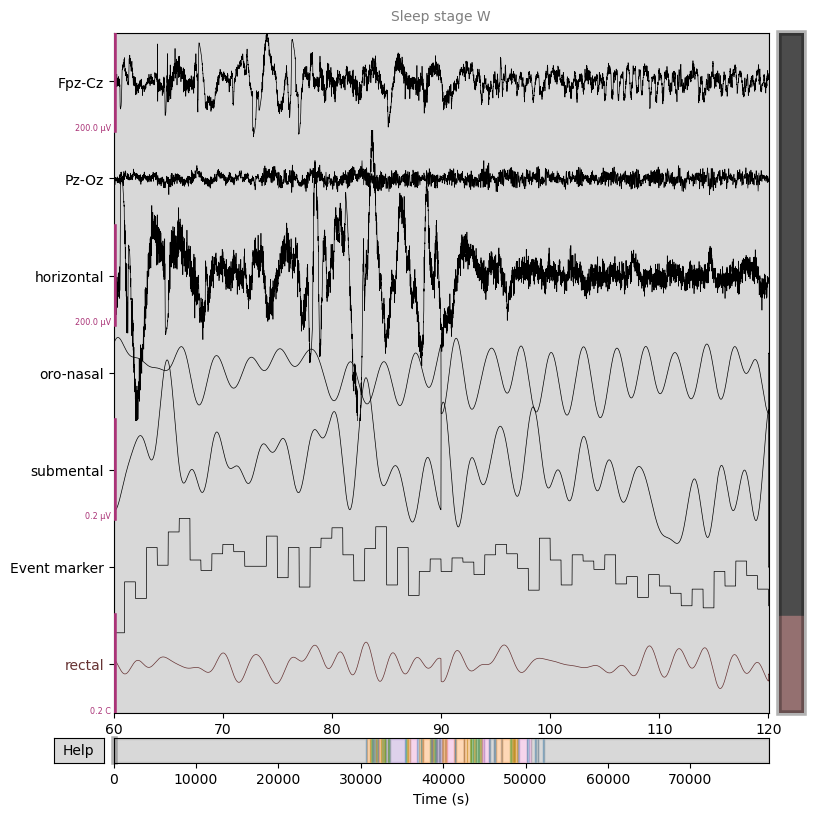

In [59]:
raw_train = mne.io.read_raw_edf(subject_0_files[0], stim_channel='Event marker', infer_types=True)
annot_train = mne.read_annotations(subject_0_files[1])
raw_train.set_annotations(annot_train, emit_warning=False)

# scalings were chosen manually to allow for simultaneous visualization of different channel types in this specific dataset
raw_train.plot(
    start=60,
    duration=60,
    scalings=dict(eeg=1e-4, resp=1e3, eog=1e-4, emg=1e-7, misc=1e-1),
);

In [60]:
print(annot_train)
print(annot_train[0])

<Annotations | 154 segments: Sleep stage 1 (24), Sleep stage 2 (40), Sleep ...>
OrderedDict([('onset', 0.0), ('duration', 30630.0), ('description', 'Sleep stage W'), ('orig_time', None)])


Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage 3', 'Sleep stage 4', 'Sleep stage R', 'Sleep stage W']


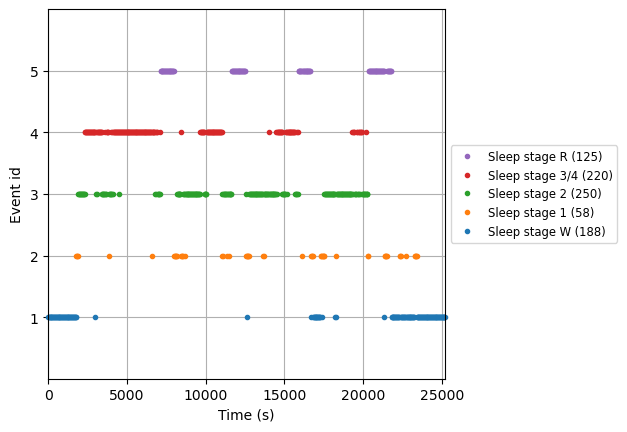

In [61]:
annotation_desc_2_event_id = {
    'Sleep stage W': 1,
    'Sleep stage 1': 2,
    'Sleep stage 2': 3,
    'Sleep stage 3': 4,
    'Sleep stage 4': 4,
    'Sleep stage R': 5,
}

# keep last 30 minutes of wake events before sleep and first 30 minutes of wake events after sleep
annot_train.crop(annot_train[1]['onset'] - 30 * 60, annot_train[-2]['onset'] + 30 * 60)
raw_train.set_annotations(annot_train, emit_warning=False)

# create one event for every 30 seconds
events_train, _ = mne.events_from_annotations(
    raw_train, event_id=annotation_desc_2_event_id, chunk_duration=30.0
)

# create a new event_id that unifies stages 3 and 4
event_id = {
    'Sleep stage W': 1,
    'Sleep stage 1': 2,
    'Sleep stage 2': 3,
    'Sleep stage 3/4': 4,
    'Sleep stage R': 5,
}

# plot events
fig = mne.viz.plot_events(
    events_train,
    event_id=event_id,
    sfreq=raw_train.info['sfreq'],
    first_samp=events_train[0, 0],
)

# keep the color-code for further plotting
stage_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [62]:
events_train.shape

(841, 3)

In [63]:
tmax = 30.0 - 1.0 / raw_train.info['sfreq']  # tmax in included

epochs_train = mne.Epochs(
    raw=raw_train,
    events=events_train,
    event_id=event_id,
    tmin=0.0,
    tmax=tmax,
    baseline=None,
)

print(epochs_train)

Not setting metadata
841 matching events found
No baseline correction applied
0 projection items activated
<Epochs |  841 events (good & bad), 0 – 29.99 s, baseline off, ~11 kB, data not loaded,
 'Sleep stage W': 188
 'Sleep stage 1': 58
 'Sleep stage 2': 250
 'Sleep stage 3/4': 220
 'Sleep stage R': 125>


In [64]:
# repeat steps for subject 1
raw_test = mne.io.read_raw_edf(subject_1_files[0], stim_channel='Event marker', infer_types=True)
annot_test = mne.read_annotations(subject_1_files[1])
raw_test.set_annotations(annot_test, emit_warning=False)

annot_test.crop(annot_test[1]['onset'] - 30 * 60, annot_test[-2]['onset'] + 30 * 60)
raw_test.set_annotations(annot_test, emit_warning=False)

# create one event for every 30 seconds
events_test, _ = mne.events_from_annotations(
    raw_test, event_id=annotation_desc_2_event_id, chunk_duration=30.0
)

epochs_test = mne.Epochs(
    raw=raw_test,
    events=events_test,
    event_id=event_id,
    tmin=0.0,
    tmax=tmax,
    baseline=None,
)

Extracting EDF parameters from /Users/sepideh/mne_data/physionet-sleep-data/SC4011E0-PSG.edf...
EDF file detected
Channel 'EEG Fpz-Cz' recognized as type EEG (renamed to 'Fpz-Cz').
Channel 'EEG Pz-Oz' recognized as type EEG (renamed to 'Pz-Oz').
Channel 'EOG horizontal' recognized as type EOG (renamed to 'horizontal').
Channel 'Resp oro-nasal' recognized as type RESP (renamed to 'oro-nasal').
Channel 'EMG submental' recognized as type EMG (renamed to 'submental').
Channel 'Temp rectal' recognized as type TEMP (renamed to 'rectal').
Setting channel info structure...
Creating raw.info structure...
Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage 3', 'Sleep stage 4', 'Sleep stage R', 'Sleep stage W']
Not setting metadata
1103 matching events found
No baseline correction applied
0 projection items activated


Loading data for 58 events and 3000 original time points ...
0 bad epochs dropped
    Using multitaper spectrum estimation with 7 DPSS windows
Averaging across epochs...
Loading data for 250 events and 3000 original time points ...


/Users/sepideh/opt/anaconda3/envs/neuroscience/lib/python3.11/site-packages/mne/viz/utils.py:151: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)


0 bad epochs dropped
    Using multitaper spectrum estimation with 7 DPSS windows
Averaging across epochs...
Loading data for 220 events and 3000 original time points ...
0 bad epochs dropped
    Using multitaper spectrum estimation with 7 DPSS windows
Averaging across epochs...
Loading data for 125 events and 3000 original time points ...
0 bad epochs dropped
    Using multitaper spectrum estimation with 7 DPSS windows
Averaging across epochs...
Loading data for 188 events and 3000 original time points ...
0 bad epochs dropped
    Using multitaper spectrum estimation with 7 DPSS windows
Averaging across epochs...
Loading data for 109 events and 3000 original time points ...
0 bad epochs dropped
    Using multitaper spectrum estimation with 7 DPSS windows
Averaging across epochs...
Loading data for 562 events and 3000 original time points ...
0 bad epochs dropped
    Using multitaper spectrum estimation with 7 DPSS windows
Averaging across epochs...
Loading data for 105 events and 3000

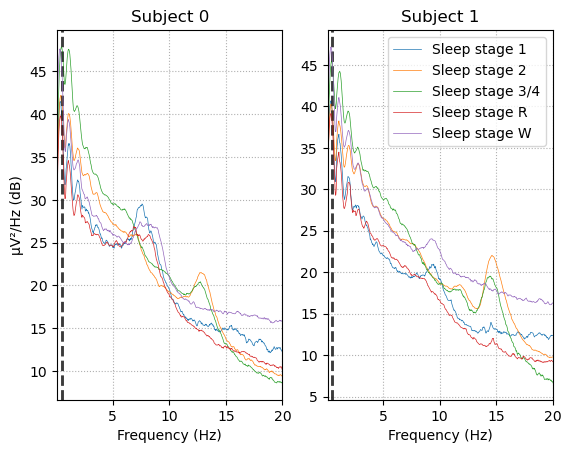

In [65]:
# visualize subject 0 vs subject 1 sleep stage power spectral densities (PSDs)
fig, (ax1, ax2) = plt.subplots(ncols=2)

# iterate over the subjects
stages = sorted(event_id.keys())
for ax, title, epochs in zip([ax1, ax2], ['Subject 0', 'Subject 1'], [epochs_train, epochs_test]):
    for stage, color in zip(stages, stage_colors):
        spectrum = epochs[stage].compute_psd(fmin=0.1, fmax=20.0)
        spectrum.plot(
            ci=None,
            color=color,
            axes=ax,
            average=True,
            spatial_colors=False,
            picks='data',
            exclude='bads',
        );
    ax.set(title=title, xlabel='Frequency (Hz)')
ax1.set(ylabel='µV²/Hz (dB)')
ax2.legend(ax2.lines[2::3], stages)

In [66]:
def eeg_power_band(epochs):
    """EEG relative power band feature extraction.

    This function takes an ``mne.Epochs`` object and creates EEG features based
    on relative power in specific frequency bands that are compatible with
    scikit-learn.

    Parameters
    ----------
    epochs : Epochs
        The data.

    Returns
    -------
    X : numpy array of shape [n_samples, 5]
        Transformed data.
    """
    # specific frequency bands
    FREQ_BANDS = {
        "delta": [0.5, 4.5],
        "theta": [4.5, 8.5],
        "alpha": [8.5, 11.5],
        "sigma": [11.5, 15.5],
        "beta": [15.5, 30],
    }

    spectrum = epochs.compute_psd(picks='eeg', fmin=0.5, fmax=30.0)
    psds, freqs = spectrum.get_data(return_freqs=True)
    # Normalize the PSDs
    psds /= np.sum(psds, axis=-1, keepdims=True)

    X = []
    for fmin, fmax in FREQ_BANDS.values():
        psds_band = psds[:, :, (freqs >= fmin) & (freqs < fmax)].mean(axis=-1)
        X.append(psds_band.reshape(len(psds), -1))

    return np.concatenate(X, axis=1)

In [67]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

pipe = make_pipeline(
    FunctionTransformer(eeg_power_band, validate=False),
    RandomForestClassifier(n_estimators=100, random_state=42),
)

# Train
y_train = epochs_train.events[:, 2]
pipe.fit(epochs_train, y_train)

# Test
y_pred = pipe.predict(epochs_test)

# Compute accuracy
y_test = epochs_test.events[:, 2]
acc = accuracy_score(y_test, y_pred)

print("Accuracy score: {}".format(acc))

Loading data for 841 events and 3000 original time points ...
0 bad epochs dropped
    Using multitaper spectrum estimation with 7 DPSS windows
Loading data for 1103 events and 3000 original time points ...
0 bad epochs dropped
    Using multitaper spectrum estimation with 7 DPSS windows
Accuracy score: 0.6854034451495921


In [68]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names=event_id.keys()))

[[154   1   0   2   0]
 [ 71  25   8   1   4]
 [ 47  33 437  25  20]
 [  0   0   4 101   0]
 [ 51  63  17   0  39]]
                 precision    recall  f1-score   support

  Sleep stage W       0.48      0.98      0.64       157
  Sleep stage 1       0.20      0.23      0.22       109
  Sleep stage 2       0.94      0.78      0.85       562
Sleep stage 3/4       0.78      0.96      0.86       105
  Sleep stage R       0.62      0.23      0.33       170

       accuracy                           0.69      1103
      macro avg       0.60      0.64      0.58      1103
   weighted avg       0.74      0.69      0.68      1103

